In [1]:
import networkx as nx
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from torch.optim import SGD
import random

**Найти набор данных для бинарной классификации рёбер в графе.**

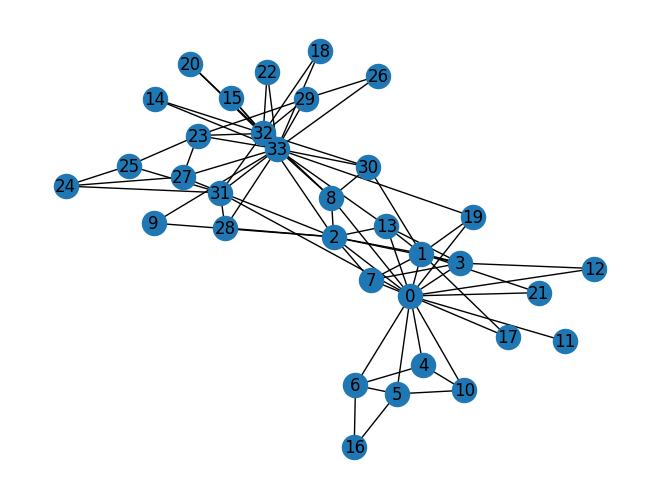

In [3]:
# take the lecture graph
G = nx.karate_club_graph()
# Visualize the graph
nx.draw(G, with_labels = True)

**Реализовать случайные блуждания алгоритма DeepWalk и построить множества схожих вершин**

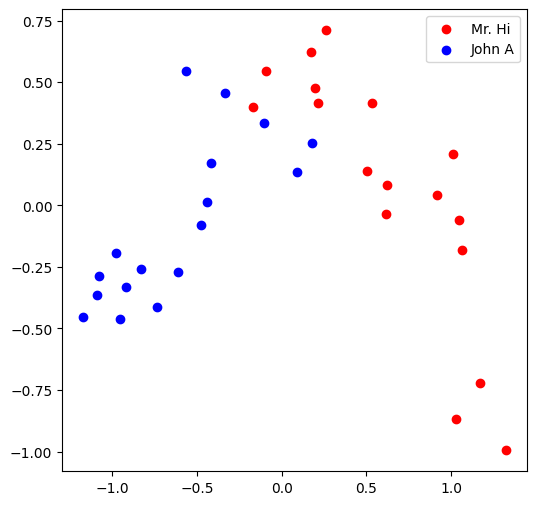

In [5]:
def DeepWalk(G, num_of_paths=10, len_of_path=10, num_negative_samples=5):
    # Initialize variables
    num_of_nodes = G.number_of_nodes()
    emb = torch.nn.Embedding(num_embeddings=num_of_nodes, embedding_dim=num_of_nodes)
    positive_nodes = []  # Array of nodes visited during walks
    negative_nodes = []  # Array of sampled nodes not visited

    # Iterate over each node in the graph
    for node in range(num_of_nodes):
        temp_emb = np.zeros(num_of_nodes)  # Current node visit frequency
        temp_pos_nodes = []  # Nodes visited during random walks
        temp_neg_nodes = np.zeros(num_negative_samples)  # Non-visited nodes

        # Run multiple random walks from the current node
        for _ in range(num_of_paths):
            current_node = node
            nodes_in_path = set()  # Unique nodes visited in the current path
            nodes_in_path.add(current_node)

            # Perform a walk of fixed length
            for _ in range(len_of_path):
                # Get available neighbors of the current node
                neighbors = list(G.neighbors(current_node))

                # Choose a random neighbor as the next node in the path
                if neighbors:
                    next_node = random.choice(neighbors)
                    nodes_in_path.add(next_node)
                    current_node = next_node

            # Update the visit frequency for nodes encountered in this path
            for visited_node in nodes_in_path:
                temp_emb[visited_node] += 1
                temp_pos_nodes.append(visited_node)

        # Determine non-visited nodes
        unvisited_nodes = [idx for idx, count in enumerate(temp_emb) if count == 0]

        # Randomly select a fixed number of non-visited nodes as negative samples
        if len(unvisited_nodes) >= num_negative_samples:
            temp_neg_nodes[:] = random.sample(unvisited_nodes, num_negative_samples)
        else:
            temp_neg_nodes[:len(unvisited_nodes)] = unvisited_nodes

        # Normalize visit frequencies and store in embedding matrix
        emb.weight.data[node] = torch.Tensor(temp_emb / num_of_paths)

        # Store lists of visited and non-visited nodes
        positive_nodes.append(temp_pos_nodes)
        negative_nodes.append(temp_neg_nodes)

    return emb, positive_nodes, np.array(negative_nodes)


def visualize_emb(emb, G):
    # Perform PCA on the embedding to reduce dimensionality to 2D for visualization
    X = emb.weight.data.numpy()
    pca = PCA(n_components=2)
    components = pca.fit_transform(X)

    # Separate nodes by attribute (club membership) for plotting
    club1_x, club1_y = [], []
    club2_x, club2_y = [], []
    for node, data in G.nodes(data=True):
        if data.get('club') == 'Mr. Hi':
            club1_x.append(components[node][0])
            club1_y.append(components[node][1])
        else:
            club2_x.append(components[node][0])
            club2_y.append(components[node][1])

    # Plot the PCA-transformed embedding, differentiating by club attribute
    plt.figure(figsize=(6, 6))
    plt.scatter(club1_x, club1_y, color="red", label="Mr. Hi")
    plt.scatter(club2_x, club2_y, color="blue", label="John A")
    plt.legend()
    plt.show()


# Example usage:
emb, pos_nodes, neg_nodes = DeepWalk(G)
visualize_emb(emb, G)

**Обучить эмбеддинги вершин, используя SGD и negative sampling.**
**Визуализировать эмбеддинги.**


Epoch 0: Loss = 488.8938


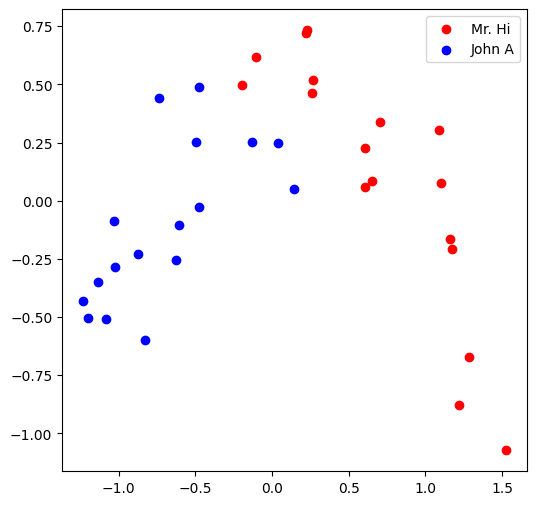

Epoch 25: Loss = 226.3537


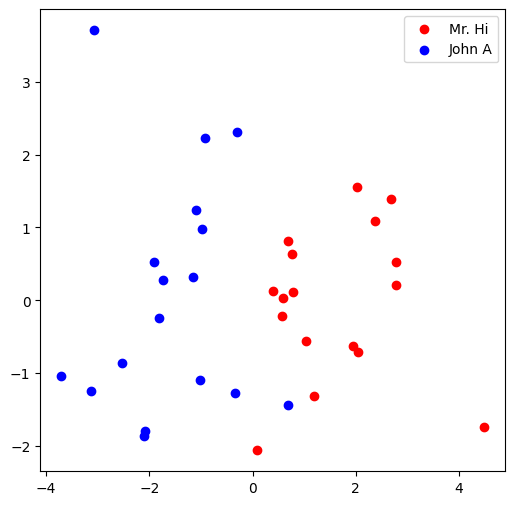

Epoch 50: Loss = 210.0038


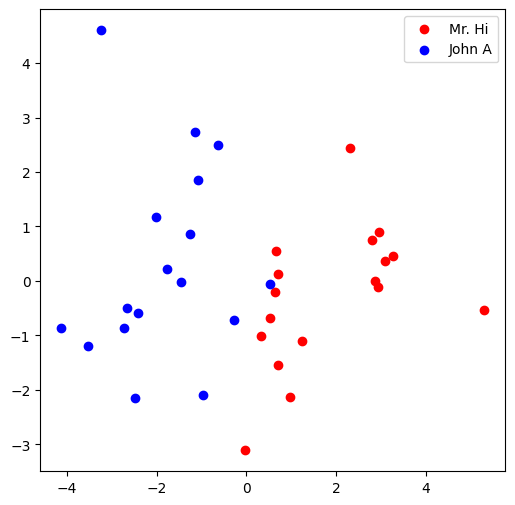

Epoch 75: Loss = 208.6154


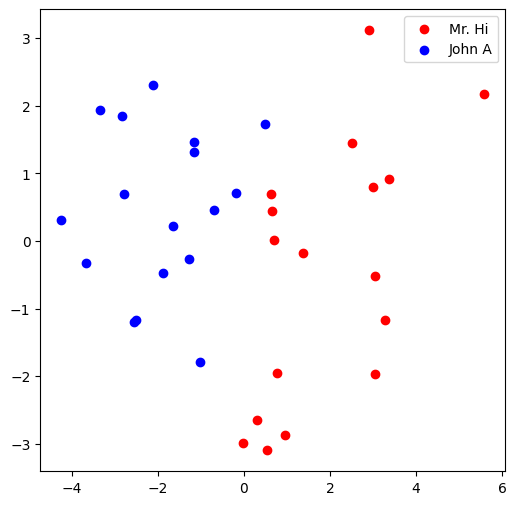

In [7]:
# Define loss computation for DeepWalk embeddings
def compute_loss(embedding, positive_samples, negative_samples):
    total_loss = 0
    num_nodes = embedding.weight.shape[0]

    # Iterate over each node
    for node_idx in range(num_nodes):
        # Positive sample processing
        for pos_neighbor in positive_samples[node_idx]:
            pos_similarity = torch.dot(embedding.weight[node_idx], embedding.weight[int(pos_neighbor)])
            total_loss += torch.log(torch.sigmoid(pos_similarity))

        # Negative sample processing
        for neg_sample in negative_samples[node_idx]:
            neg_similarity = torch.dot(embedding.weight[node_idx], embedding.weight[int(neg_sample)])
            total_loss += torch.log(torch.sigmoid(-neg_similarity))

    return -total_loss  # Return negative of accumulated loss


# Train function for optimizing embedding
def optimize_embedding(embedding, positive_samples, negative_samples, G):
    epochs = 100
    lr = 0.01
    optimizer = SGD(embedding.parameters(), lr=lr, momentum=0.9)

    for epoch in range(epochs):
        optimizer.zero_grad()  # Reset gradients
        loss_value = compute_loss(embedding, positive_samples, negative_samples)
        loss_value.backward()  # Backpropagate
        optimizer.step()  # Update embedding weights

        # Periodically log loss and visualize
        if epoch % 25 == 0:
            print(f"Epoch {epoch}: Loss = {loss_value.item():.4f}")
            visualize_emb(embedding, G)  # Pass G here


# Example training call with G included
optimize_embedding(emb, pos_nodes, neg_nodes, G)

**(+5 баллов) Также реализовать node2vec блуждания и обучить классификатор, используя его. Сравнить результаты.**

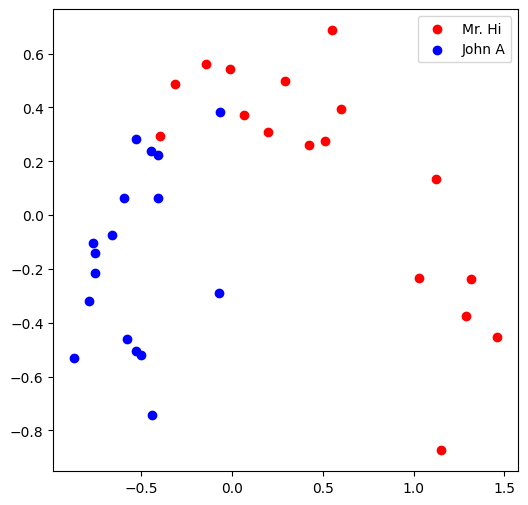

Epoch 0: Loss = 549.5773


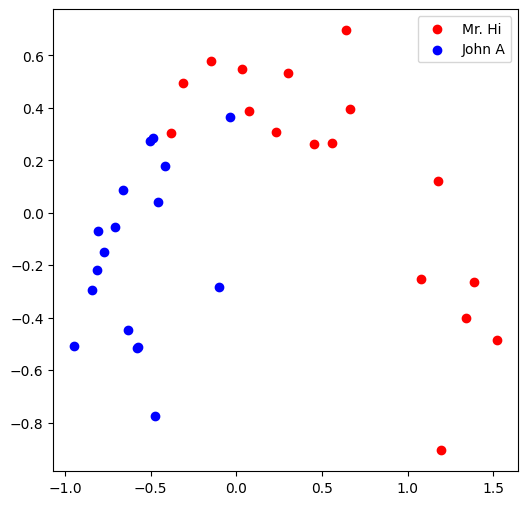

Epoch 25: Loss = 255.0370


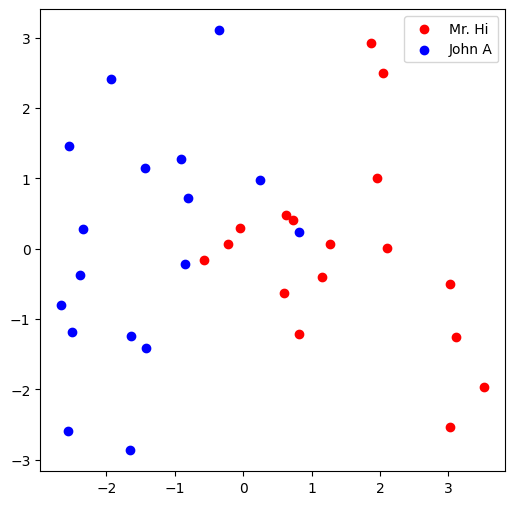

Epoch 50: Loss = 242.7318


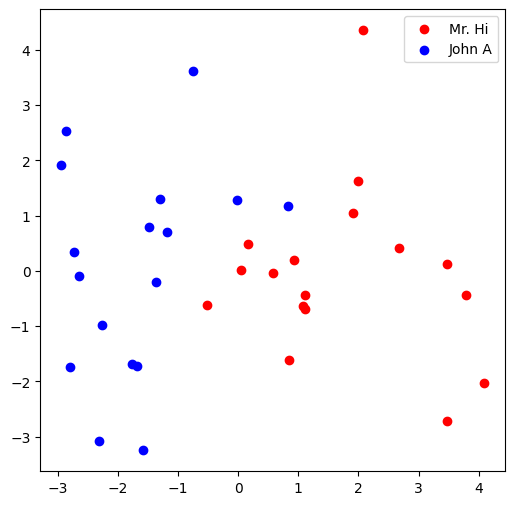

Epoch 75: Loss = 241.8719


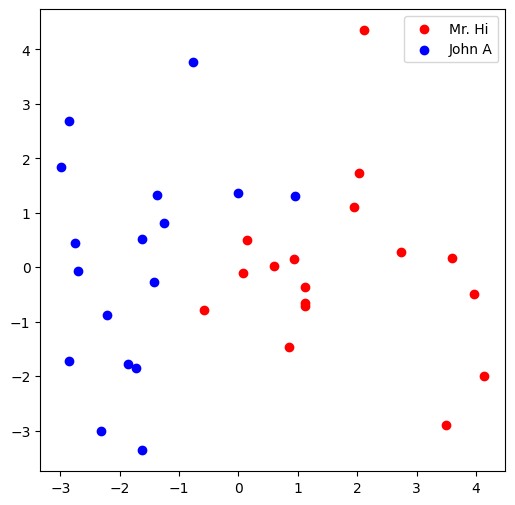

In [11]:
def Node2Vec(G, num_of_paths=10, len_of_path=10, num_negative_samples=5, p=1, q=0.5):
    num_of_nodes = G.number_of_nodes()
    emb = torch.nn.Embedding(num_embeddings=num_of_nodes, embedding_dim=num_of_nodes)
    positive_nodes = []
    negative_nodes = []

    for start_node in range(num_of_nodes):
        temp_emb = np.zeros(num_of_nodes)
        temp_pos_nodes = []
        temp_neg_nodes = np.zeros(num_negative_samples)

        prev_node = start_node
        prev_node_neighbors = set(G.neighbors(prev_node))

        for _ in range(num_of_paths):
            current_node = start_node
            visited_nodes = set([current_node])

            for _ in range(len_of_path):
                neighbors = []
                for neighbor in G.neighbors(current_node):
                    if neighbor == prev_node:
                        neighbors.extend([neighbor] * int(1 / p))
                    elif neighbor in prev_node_neighbors:
                        neighbors.append(neighbor)
                    else:
                        neighbors.extend([neighbor] * int(1 / q))

                if neighbors:
                    next_node = random.choice(neighbors)
                    visited_nodes.add(next_node)
                    prev_node = current_node
                    current_node = next_node
                    prev_node_neighbors = set(G.neighbors(prev_node))

            for node in visited_nodes:
                temp_emb[node] += 1
                temp_pos_nodes.append(node)

        unvisited_nodes = [idx for idx, count in enumerate(temp_emb) if count == 0]
        if len(unvisited_nodes) >= num_negative_samples:
            temp_neg_nodes[:] = random.sample(unvisited_nodes, num_negative_samples)
        else:
            temp_neg_nodes[:len(unvisited_nodes)] = unvisited_nodes

        emb.weight.data[start_node] = torch.Tensor(temp_emb / num_of_paths)
        positive_nodes.append(temp_pos_nodes)
        negative_nodes.append(temp_neg_nodes)

    return emb, positive_nodes, np.array(negative_nodes)

def loss_function(embedding, positive_samples, negative_samples):
    V = len(embedding.weight)
    total_loss = 0

    for u in range(V):
        pos_neighbors = positive_samples[u]
        for v in pos_neighbors:
            dot_product = torch.dot(embedding.weight[u], embedding.weight[int(v)])
            total_loss += torch.log(torch.sigmoid(dot_product))

        neg_neighbors = negative_samples[u]
        for i in neg_neighbors:
            dot_product_neg = torch.dot(embedding.weight[u], embedding.weight[int(i)])
            total_loss += torch.log(torch.sigmoid(-dot_product_neg))

    return -total_loss

def train(embedding, positive_samples, negative_samples, epochs=100, learning_rate=0.01):
    optimizer = SGD(embedding.parameters(), lr=learning_rate, momentum=0.9)
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = loss_function(embedding, positive_samples, negative_samples)
        loss.backward()
        optimizer.step()

        if epoch % 25 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.4f}")
            visualize_emb(embedding, G)

def visualize_emb(emb, G):
    X = emb.weight.data.numpy()
    pca = PCA(n_components=2)
    components = pca.fit_transform(X)

    club1_x, club1_y = [], []
    club2_x, club2_y = [], []
    for node, data in G.nodes(data=True):
        if data.get('club') == 'Mr. Hi':
            club1_x.append(components[node][0])
            club1_y.append(components[node][1])
        else:
            club2_x.append(components[node][0])
            club2_y.append(components[node][1])

    plt.figure(figsize=(6, 6))
    plt.scatter(club1_x, club1_y, color="red", label="Mr. Hi")
    plt.scatter(club2_x, club2_y, color="blue", label="John A")
    plt.legend()
    plt.show()

# Example usage
emb2, pos_nodes2, neg_nodes2 = Node2Vec(G)
visualize_emb(emb2, G)
train(emb2, pos_nodes2, neg_nodes2)

**Выводы**:
* По результатам тестирования DeepWalk показал лучшие результаты по значению ошибки, а также в методе node2vec видны периодически единичные выбросы